In [4]:
%system kaggle datasets download -d gpiosenka/cats-in-the-wild-image-classification


["Warning: Your Kaggle API key is readable by other users on this system! To fix this, you can run 'chmod 600 /home/averrous/.kaggle/kaggle.json'",
 'Downloading cats-in-the-wild-image-classification.zip to /home/averrous/dev/projects/ml/vision/big-cats-of-the-wild',
 '',
 '  0%|          | 0.00/123M [00:00<?, ?B/s]',
 '  1%|          | 1.00M/123M [00:00<01:53, 1.13MB/s]',
 '  2%|▏         | 2.00M/123M [00:01<01:06, 1.92MB/s]',
 '  2%|▏         | 3.00M/123M [00:01<00:48, 2.62MB/s]',
 '  3%|▎         | 4.00M/123M [00:01<00:35, 3.51MB/s]',
 '  4%|▍         | 5.00M/123M [00:01<00:33, 3.73MB/s]',
 '  5%|▍         | 6.00M/123M [00:02<00:30, 3.97MB/s]',
 '  6%|▌         | 7.00M/123M [00:02<00:25, 4.72MB/s]',
 '  6%|▋         | 8.00M/123M [00:02<00:23, 5.09MB/s]',
 '  7%|▋         | 9.00M/123M [00:02<00:24, 4.90MB/s]',
 '  8%|▊         | 10.0M/123M [00:02<00:21, 5.41MB/s]',
 '  9%|▉         | 11.0M/123M [00:02<00:19, 6.13MB/s]',
 ' 10%|▉         | 12.0M/123M [00:02<00:17, 6.65MB/s]',
 ' 11%|█

In [5]:
%system mv ./cats-in-the-wild-image-classification.zip ./blob


[]

In [2]:
import os
import zipfile

zip_file = './blob/cats-in-the-wild-image-classification.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('./blob')
zip_ref.close()

In [3]:
import pandas as pd

data = pd.read_csv('./blob/WILDCATS.CSV')
data.head()

,class id,filepaths,labels,data set,scientific name
0,0,train/AFRICAN LEOPARD/001.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
1,0,train/AFRICAN LEOPARD/002.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
2,0,train/AFRICAN LEOPARD/003.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
3,0,train/AFRICAN LEOPARD/004.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus
4,0,train/AFRICAN LEOPARD/005.jpg,AFRICAN LEOPARD,train,Panthera pardus pardus


In [4]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [ ]:
data.value_counts('labels')

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimage

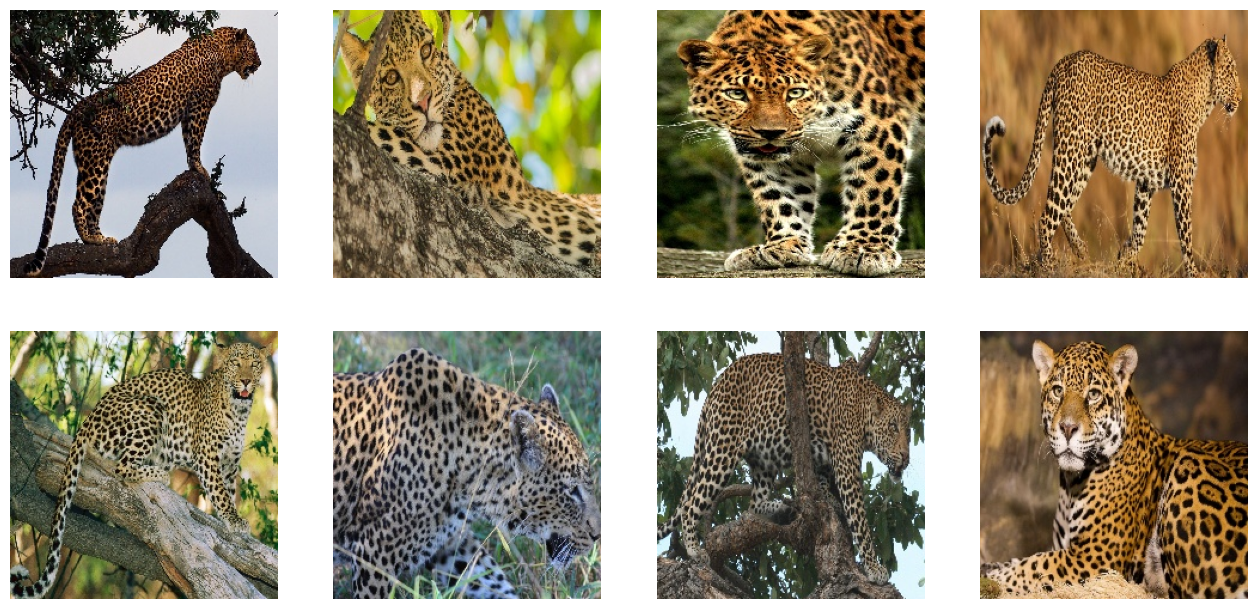

In [6]:
fig = plt.gcf()

fig.set_size_inches(4 * 4, 4 * 4)



for i, img_path in enumerate(data["filepaths"][0:8]):
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')
    img = mpimage.imread(os.path.join("./blob/",img_path))
    plt.imshow(img)

plt.show()

In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
# print("Num GPUs Available: ", tf.config.list_physical_devices("GPU"))
import logging
# tf.get_logger().setLevel(logging.ERROR)
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.compat.v1.Session(config=config)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


## Models

In [8]:
from keras import layers, Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import RMSprop, Optimizer


In [34]:


train_datagen = ImageDataGenerator(rescale=1./ 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                  )
validation_datagen = ImageDataGenerator(rescale=1./255)


data_train, data_val = train_test_split(data, test_size=0.2, shuffle=True)

train_generator = train_datagen.flow_from_dataframe(data_train, 
                                                    "./blob", 
                                                    "filepaths", 
                                                    "labels",
                                                    target_size=(224,224),
                                                    batch_size=5,
                                                    class_mode="categorical",
                                                    shuffle=True)
validation_generator = train_datagen.flow_from_dataframe(data_val, 
                                                    "./blob", 
                                                    "filepaths", 
                                                    "labels",
                                                    target_size=(224,224),
                                                    batch_size=5,
                                                    class_mode="categorical",
                                                    shuffle=True)



Found 1951 validated image filenames belonging to 10 classes.
Found 488 validated image filenames belonging to 10 classes.


##### 4 CNN, 1 Dense 128

In [36]:
img_input = layers.Input(shape=(224, 224, 3))

x = layers.Conv2D(64, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(512, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(10, activation='softmax')(x)
model = Model(img_input, output)
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.01),
              metrics=['acc'])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_19 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 54, 54, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 52, 52, 256)       2951

In [37]:
# FIRST RUNS
history = model.fit(train_generator,validation_data=validation_generator, steps_per_epoch=350, epochs=30, verbose=1, validation_steps=85)

Epoch 1/30
350/350 [==============================] - 23s 61ms/step - loss: 2.2876 - acc: 0.1157 - val_loss: 2.1425 - val_acc: 0.1718
Epoch 2/30
350/350 [==============================] - 20s 58ms/step - loss: 1.9835 - acc: 0.2354 - val_loss: 1.7737 - val_acc: 0.3082
Epoch 3/30
350/350 [==============================] - 22s 61ms/step - loss: 1.8036 - acc: 0.2978 - val_loss: 1.6255 - val_acc: 0.3271
Epoch 4/30
350/350 [==============================] - 20s 56ms/step - loss: 1.6801 - acc: 0.3459 - val_loss: 1.8121 - val_acc: 0.3365
Epoch 5/30
350/350 [==============================] - 23s 65ms/step - loss: 1.5478 - acc: 0.3998 - val_loss: 1.4011 - val_acc: 0.4682
Epoch 6/30
350/350 [==============================] - 21s 61ms/step - loss: 1.4574 - acc: 0.4542 - val_loss: 1.7763 - val_acc: 0.4000
Epoch 7/30
350/350 [==============================] - 21s 59ms/step - loss: 1.3843 - acc: 0.4593 - val_loss: 1.2826 - val_acc: 0.5129
Epoch 8/30
350/350 [==============================] - 21s 60ms

In [ ]:
result = model.predict(train_generator)

##### 5 CNN, 1 Dense 512

In [30]:
img_input = layers.Input(shape=(224, 224, 3))

x = layers.Conv2D(64, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(512, 3, activation='relu')(x)
x = layers.Conv2D(512, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
output = layers.Dense(10, activation='softmax')(x)
model_2 = Model(img_input, output)
model_2.summary()
model_2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.01),
              metrics=['acc'])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 54, 54, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 52, 52, 256)       2951

In [31]:
history_2 = model_2.fit(train_generator,validation_data=validation_generator, steps_per_epoch=350, epochs=30, verbose=1, validation_steps=85)

Epoch 1/30
350/350 [==============================] - 26s 68ms/step - loss: 2.7112 - acc: 0.1065 - val_loss: 2.3888 - val_acc: 0.0894
Epoch 2/30
350/350 [==============================] - 24s 69ms/step - loss: 2.2827 - acc: 0.1523 - val_loss: 2.1109 - val_acc: 0.2259
Epoch 3/30
350/350 [==============================] - 24s 67ms/step - loss: 1.9977 - acc: 0.2440 - val_loss: 1.9190 - val_acc: 0.3176
Epoch 4/30
350/350 [==============================] - 24s 68ms/step - loss: 1.8144 - acc: 0.3104 - val_loss: 1.8281 - val_acc: 0.2988
Epoch 5/30
350/350 [==============================] - 25s 70ms/step - loss: 1.7320 - acc: 0.3568 - val_loss: 1.7196 - val_acc: 0.3600
Epoch 6/30
350/350 [==============================] - 26s 73ms/step - loss: 1.6248 - acc: 0.3889 - val_loss: 1.5710 - val_acc: 0.3741
Epoch 7/30
350/350 [==============================] - 24s 70ms/step - loss: 1.5389 - acc: 0.4164 - val_loss: 1.9034 - val_acc: 0.3435
Epoch 8/30
350/350 [==============================] - 25s 71ms

In [ ]:
img_input = layers.Input(shape=(224, 224, 3))

x = layers.Conv2D(64, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(512, 3, activation='relu')(x)
x = layers.Conv2D(512, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
output = layers.Dense(10, activation='softmax')(x)
model_2 = Model(img_input, output)
model_2.summary()
model_2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.01),
              metrics=['acc'])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 54, 54, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 52, 52, 256)       2951

In [ ]:
print(train_generator.filenames[1])
print(train_generator.labels[1])
print(train_generator.class_indices)
result[1]

In [ ]:
import numpy as np
keys = list(train_generator.class_indices.keys())
result_category = list(map(lambda x: keys[np.argmax(x)], result))
print(result_category)